In [4]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

# 📝 Training a Classifier 🤖📚

This is it. You have seen how to define neural networks, compute loss
and make updates to the weights of the network.

Now you might be thinking,

## What about data?


Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a `torch.*Tensor`.

-   For images, packages such as Pillow, OpenCV are useful
-   For audio, packages such as scipy and librosa
-   For text, either raw Python or Cython based loading, or NLTK and
    SpaCy are useful

Specifically for vision, we have created a package called `torchvision`,
that has data loaders for common datasets such as ImageNet, CIFAR10,
MNIST, etc. and data transformers for images, viz.,
`torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes:
'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
'ship', 'truck'. The images in CIFAR-10 are of size 3x32x32, i.e.
3-channel color images of 32x32 pixels in size.

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)

## Training an image classifier


We will do the following steps in order:

1.  Load and normalize the CIFAR10 training and test datasets using
    `torchvision`
2.  Define a Convolutional Neural Network
3.  Define a loss function
4.  Train the network on the training data
5.  Test the network on the test data

### 1. Load and normalize CIFAR10

Using `torchvision`, it's extremely easy to load CIFAR10.


In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range \[0,
1\]. We transform them to Tensors of normalized range \[-1, 1\].


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>If running on Windows and you get a BrokenPipeError, try settingthe num_worker of torch.utils.data.DataLoader() to 0.</p>

</div>



In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Let us show some of the training images, for fun.


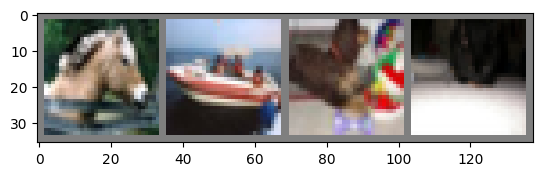

horse ship  dog   cat  


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

2. Define a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and
modify it to take 3-channel images (instead of 1-channel images as it
was defined).


In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. Define a Loss function and optimizer

Let\'s use a Classification Cross-Entropy loss and SGD with momentum.


In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network

This is when things start to get interesting. We simply have to loop
over our data iterator, and feed the inputs to the network and optimize.


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

print("Finished Training")

PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 2.188
[1,  4000] loss: 1.817
[1,  6000] loss: 1.657
[1,  8000] loss: 1.577
[1, 10000] loss: 1.535
[1, 12000] loss: 1.486
[2,  2000] loss: 1.395
[2,  4000] loss: 1.390
[2,  6000] loss: 1.365
[2,  8000] loss: 1.317
[2, 10000] loss: 1.304
[2, 12000] loss: 1.292
Finished Training


Let\'s quickly save our trained model:


See [here](https://pytorch.org/docs/stable/notes/serialization.html) for
more details on saving PyTorch models.

5. Test the network on the test data

We have trained the network for 2 passes over the training dataset. But
we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get
familiar.


In [10]:
PATH = "./cifar_net.pth"
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

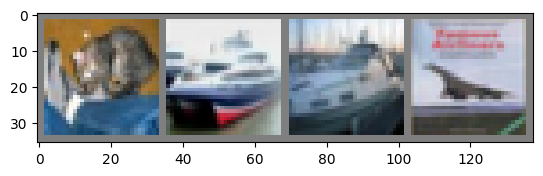

GroundTruth:  cat   ship  ship  plane


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(4)))

Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):


Okay, now let us see what the neural network thinks these examples above
are:


In [12]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a
class, the more the network thinks that the image is of the particular
class. So, let\'s get the index of the highest energy:


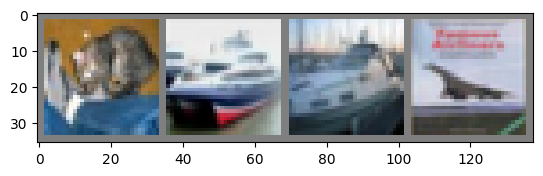

Actual:  cat   ship  ship  plane
Predicted:  cat   ship  ship  ship 


In [18]:
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))
print("Actual: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(4)))
print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct // total} %")

Accuracy of the network on the 10000 test images: 38 %


That looks way better than chance, which is 10% accuracy (randomly
picking a class out of 10 classes). Seems like the network learnt
something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:


In [20]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Move data to the device
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label.item()]] += 1
            total_pred[classes[label.item()]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

Accuracy for class: plane is 55.8 %
Accuracy for class: car   is 51.5 %
Accuracy for class: bird  is 1.6 %
Accuracy for class: cat   is 2.1 %
Accuracy for class: deer  is 16.2 %
Accuracy for class: dog   is 46.8 %
Accuracy for class: frog  is 51.6 %
Accuracy for class: horse is 62.9 %
Accuracy for class: ship  is 43.0 %
Accuracy for class: truck is 53.1 %


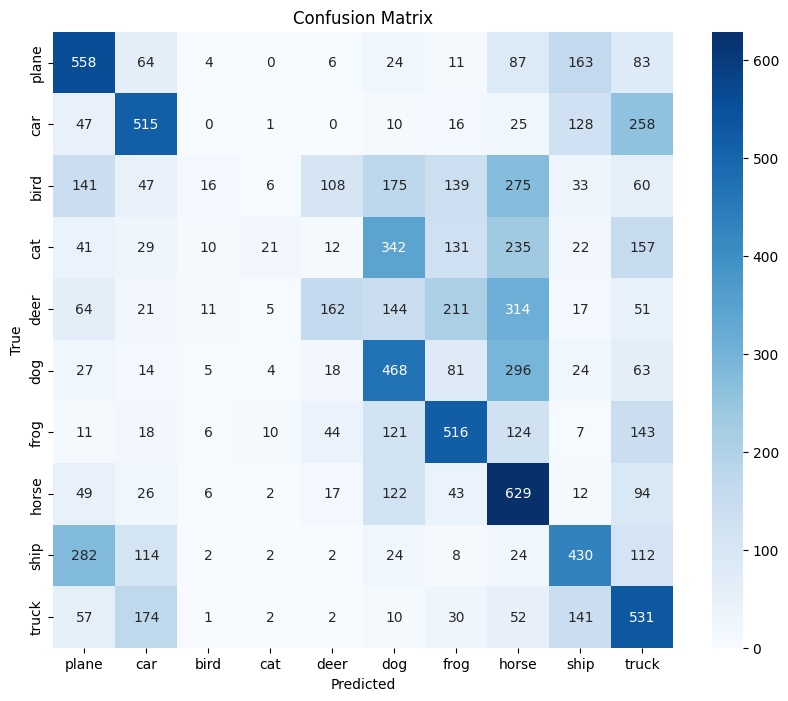

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Initialize the prediction and label lists(tensors)
predlist = torch.zeros(0, dtype=torch.long, device="cpu")
lbllist = torch.zeros(0, dtype=torch.long, device="cpu")

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        predlist = torch.cat([predlist, predictions.view(-1).cpu()])
        lbllist = torch.cat([lbllist, labels.view(-1).cpu()])

# Confusion matrix
conf_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transforms
transform = transforms.Compose(
    [
        transforms.Resize(224),  # ResNet expects 224x224
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Load CIFAR-10
batch_size = 64
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

# Load pretrained ResNet18
model = resnet18(pretrained=True)

# Modify the final layer for 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop (1 epoch for demo)
for epoch in range(1):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")

# Evaluation
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

Using device: cuda


/home/jca92/anaconda3/envs/engr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jca92/anaconda3/envs/engr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jca92/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 297MB/s]


[Epoch 1, Batch 100] loss: 0.788
[Epoch 1, Batch 200] loss: 0.362
[Epoch 1, Batch 300] loss: 0.274
[Epoch 1, Batch 400] loss: 0.250
[Epoch 1, Batch 500] loss: 0.242
[Epoch 1, Batch 600] loss: 0.241
[Epoch 1, Batch 700] loss: 0.214
Finished Training
Accuracy on test set: 93.02%


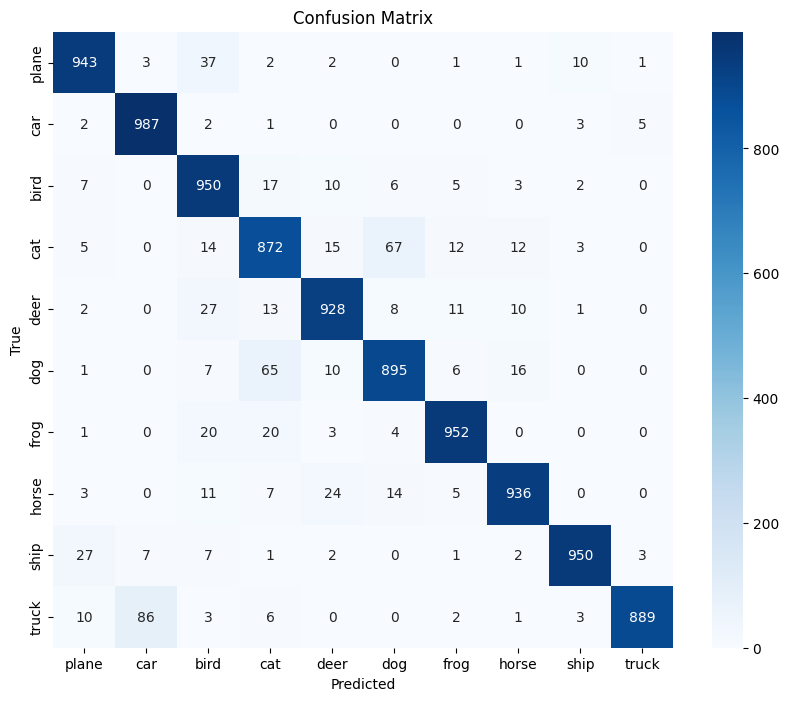

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get all predictions and true labels
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()